<a href="https://colab.research.google.com/github/aaltinoz/municipalities/blob/main/municipality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Get data
!wget https://raw.githubusercontent.com/aaltinoz/municipalities/main/municipality_bus_utilization.csv

--2022-11-13 22:02:12--  https://raw.githubusercontent.com/aaltinoz/municipalities/main/municipality_bus_utilization.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418504 (409K) [text/plain]
Saving to: ‘municipality_bus_utilization.csv’

municipality_bus_ut 100%[===================>] 408.70K  --.-KB/s    in 0.04s   

2022-11-13 22:02:12 (11.1 MB/s) - ‘municipality_bus_utilization.csv’ saved [418504/418504]



TASK: Forecasting bus demand in Banana Republic municipalities.

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you (https://pi.works/3w8IJbV). 
The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values):

MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY
where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.

The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.)

The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately.
Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

In [2]:
# Get libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Lets get data as dataframe
df = pd.read_csv("/content/municipality_bus_utilization.csv",
                 parse_dates = ["timestamp"],
                 index_col= ["timestamp"])
display(df.head(), df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13070 entries, 2017-06-04 07:59:42 to 2017-08-19 16:30:35
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   municipality_id  13070 non-null  int64
 1   usage            13070 non-null  int64
 2   total_capacity   13070 non-null  int64
dtypes: int64(3)
memory usage: 408.4 KB


municipality_id  usage  total_capacity
timestamp                                                  
2017-06-04 07:59:42                9    454            1332
2017-06-04 07:59:42                8    556            2947
2017-06-04 07:59:42                4   1090            3893
2017-06-04 07:59:42                0    204            2813
2017-06-04 07:59:42                7    718            2019

None

municipality_id         usage  total_capacity
count     13070.000000  13070.000000    13070.000000
mean          4.500000    876.002984     1972.800000
std           2.872391    679.287109     1144.074782
min           0.000000     11.000000      397.000000
25%           2.000000    403.000000      697.000000
50%           4.500000    692.000000     1974.500000
75%           7.000000   1190.000000     2947.000000
max           9.000000   3508.000000     3893.000000

In [4]:
# Check whether it is got any missing values
display(df.index.isna().sum(),df.isna().sum())

0

municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [5]:
# Lets make an initial preprocess function
# I dont like 0,1,2.. as column names makes pandas raise errors lets change that
mapping = {0: "A0", 1: "B1", 2: "C2", 3: "D3", 4: "E4", 5: "F5", 6: "G6", 7: "H7", 8: "I8", 9: "J9"}
def tweak_df(df): 
  return(df
        # .assign(day = df.index.day, # Aggregate new columns from date index
        #         month = df.index.month,
        #         hour = df.index.hour,
        #         minute = df.index.minute,
        #         second = df.index.second 
        #       )
        .assign(municipality = df.municipality_id.map(mapping))
        .astype({"municipality": "category", "usage": "int16", "total_capacity": "int16"}) # MemoryUsage before 941040 now  ->  170290/941040 --> %73
        .drop(columns=["municipality_id"])
        #.memory_usage(deep=True).sum()
        )
df = tweak_df(df) # Apply preprocess to data frame

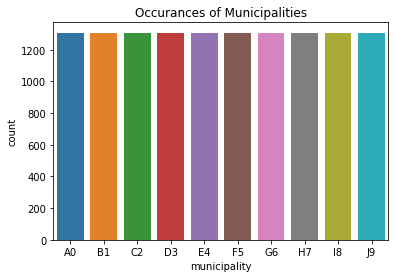

In [6]:
# Check the number of occurances of municipalities
sns.countplot(x=df.municipality)
plt.title("Occurances of Municipalities");

In [7]:
# Lets pivot the table to get individual usages and capacities
df = df.pivot( columns = "municipality", values = ["usage", "total_capacity"])
df

usage                                               \
municipality             A0     B1     C2      D3      E4     F5      G6   
timestamp                                                                  
2017-06-04 07:59:42   204.0  129.0  273.0   623.0  1090.0   70.0   597.0   
2017-06-04 08:25:42   247.0  138.0  311.0   770.0  1476.0   73.0   687.0   
2017-06-04 08:59:42   332.0  164.0  355.0   967.0  2016.0   89.0   801.0   
2017-06-04 09:32:46   429.0  213.0  423.0  1130.0  2511.0  116.0   941.0   
2017-06-04 09:59:48   485.0  245.0  494.0  1263.0  2811.0  159.0  1061.0   
...                     ...    ...    ...     ...     ...    ...     ...   
2017-08-19 14:30:33  1285.0  410.0  677.0  1526.0  3176.0  318.0  1849.0   
2017-08-19 15:03:34  1283.0  408.0  651.0  1496.0  3111.0  309.0  1829.0   
2017-08-19 15:29:33  1286.0  411.0  617.0  1441.0  2980.0  283.0  1790.0   
2017-08-19 16:03:35  1276.0  401.0  580.0  1330.0  2779.0  239.0  1727.0   
2017-08-19 16:30:35  1271.0  396.0  548.0  1189.0  2542.0  202.0  1680.0   

                                           total_capacity                \
municipality             H7      I8     J9             A0     B1     C2   
timestamp                                                                 
2017-06-04 07:59:42   718.0   556.0  454.0         2813.0  397.0  697.0   
2017-06-04 08:25:42   789.0   674.0  487.0         2813.0  397.0  697.0   
2017-06-04 08:59:42   873.0   857.0  527.0         2813.0  397.0  697.0   
2017-06-04 09:32:46  1013.0  1045.0  599.0         2813.0  397.0  697.0   
2017-06-04 09:59:48  1151.0  1172.0  666.0         2813.0  397.0  697.0   
...                     ...     ...    ...            ...    ...    ...   
2017-08-19 14:30:33  1651.0  1341.0  983.0         2813.0  397.0  697.0   
2017-08-19 15:03:34  1618.0  1336.0  976.0         2813.0  397.0  697.0   
2017-08-19 15:29:33  1562.0  1315.0  954.0         2813.0  397.0  697.0   
2017-08-19 16:03:35  1450.0  1253.0  879.0         2813.0  397.0  697.0   
2017-08-19 16:30:35  1354.0  1193.0  815.0         2813.0  397.0  697.0   

                                                                            
municipality             D3      E4     F5      G6      H7      I8      J9  
timestamp                                                                   
2017-06-04 07:59:42  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-06-04 08:25:42  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-06-04 08:59:42  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-06-04 09:32:46  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-06-04 09:59:48  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
...                     ...     ...    ...     ...     ...     ...     ...  
2017-08-19 14:30:33  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-08-19 15:03:34  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-08-19 15:29:33  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-08-19 16:03:35  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  
2017-08-19 16:30:35  1930.0  3893.0  587.0  3113.0  2019.0  2947.0  1332.0  

[1309 rows x 20 columns]

In [8]:
# Lets change column names and make it single level column
df.columns = ['_'.join(col) for col in df.columns]
df

usage_A0  usage_B1  usage_C2  usage_D3  usage_E4  \
timestamp                                                               
2017-06-04 07:59:42     204.0     129.0     273.0     623.0    1090.0   
2017-06-04 08:25:42     247.0     138.0     311.0     770.0    1476.0   
2017-06-04 08:59:42     332.0     164.0     355.0     967.0    2016.0   
2017-06-04 09:32:46     429.0     213.0     423.0    1130.0    2511.0   
2017-06-04 09:59:48     485.0     245.0     494.0    1263.0    2811.0   
...                       ...       ...       ...       ...       ...   
2017-08-19 14:30:33    1285.0     410.0     677.0    1526.0    3176.0   
2017-08-19 15:03:34    1283.0     408.0     651.0    1496.0    3111.0   
2017-08-19 15:29:33    1286.0     411.0     617.0    1441.0    2980.0   
2017-08-19 16:03:35    1276.0     401.0     580.0    1330.0    2779.0   
2017-08-19 16:30:35    1271.0     396.0     548.0    1189.0    2542.0   

                     usage_F5  usage_G6  usage_H7  usage_I8  usage_J9  \
timestamp                                                               
2017-06-04 07:59:42      70.0     597.0     718.0     556.0     454.0   
2017-06-04 08:25:42      73.0     687.0     789.0     674.0     487.0   
2017-06-04 08:59:42      89.0     801.0     873.0     857.0     527.0   
2017-06-04 09:32:46     116.0     941.0    1013.0    1045.0     599.0   
2017-06-04 09:59:48     159.0    1061.0    1151.0    1172.0     666.0   
...                       ...       ...       ...       ...       ...   
2017-08-19 14:30:33     318.0    1849.0    1651.0    1341.0     983.0   
2017-08-19 15:03:34     309.0    1829.0    1618.0    1336.0     976.0   
2017-08-19 15:29:33     283.0    1790.0    1562.0    1315.0     954.0   
2017-08-19 16:03:35     239.0    1727.0    1450.0    1253.0     879.0   
2017-08-19 16:30:35     202.0    1680.0    1354.0    1193.0     815.0   

                     total_capacity_A0  total_capacity_B1  total_capacity_C2  \
timestamp                                                                      
2017-06-04 07:59:42             2813.0              397.0              697.0   
2017-06-04 08:25:42             2813.0              397.0              697.0   
2017-06-04 08:59:42             2813.0              397.0              697.0   
2017-06-04 09:32:46             2813.0              397.0              697.0   
2017-06-04 09:59:48             2813.0              397.0              697.0   
...                                ...                ...                ...   
2017-08-19 14:30:33             2813.0              397.0              697.0   
2017-08-19 15:03:34             2813.0              397.0              697.0   
2017-08-19 15:29:33             2813.0              397.0              697.0   
2017-08-19 16:03:35             2813.0              397.0              697.0   
2017-08-19 16:30:35             2813.0              397.0              697.0   

                     total_capacity_D3  total_capacity_E4  total_capacity_F5  \
timestamp                                                                      
2017-06-04 07:59:42             1930.0             3893.0              587.0   
2017-06-04 08:25:42             1930.0             3893.0              587.0   
2017-06-04 08:59:42             1930.0             3893.0              587.0   
2017-06-04 09:32:46             1930.0             3893.0              587.0   
2017-06-04 09:59:48             1930.0             3893.0              587.0   
...                                ...                ...                ...   
2017-08-19 14:30:33             1930.0             3893.0              587.0   
2017-08-19 15:03:34             1930.0             3893.0              587.0   
2017-08-19 15:29:33             1930.0             3893.0              587.0   
2017-08-19 16:03:35             1930.0             3893.0              587.0   
2017-08-19 16:30:35             1930.0             3893.0              587.0   

                     total_capacity_G6 

In [9]:
# Lets check for Missing Values
df.isnull().sum()

usage_A0             2
usage_B1             2
usage_C2             2
usage_D3             2
usage_E4             2
usage_F5             2
usage_G6             2
usage_H7             2
usage_I8             2
usage_J9             2
total_capacity_A0    2
total_capacity_B1    2
total_capacity_C2    2
total_capacity_D3    2
total_capacity_E4    2
total_capacity_F5    2
total_capacity_G6    2
total_capacity_H7    2
total_capacity_I8    2
total_capacity_J9    2
dtype: int64

In [10]:
# Lets Handle Missing Values with respective means
for i in df.columns:
  df[i] = df[i].fillna(df[i].mean())

In [11]:
# Lets Check again
df.isna().sum()

usage_A0             0
usage_B1             0
usage_C2             0
usage_D3             0
usage_E4             0
usage_F5             0
usage_G6             0
usage_H7             0
usage_I8             0
usage_J9             0
total_capacity_A0    0
total_capacity_B1    0
total_capacity_C2    0
total_capacity_D3    0
total_capacity_E4    0
total_capacity_F5    0
total_capacity_G6    0
total_capacity_H7    0
total_capacity_I8    0
total_capacity_J9    0
dtype: int64

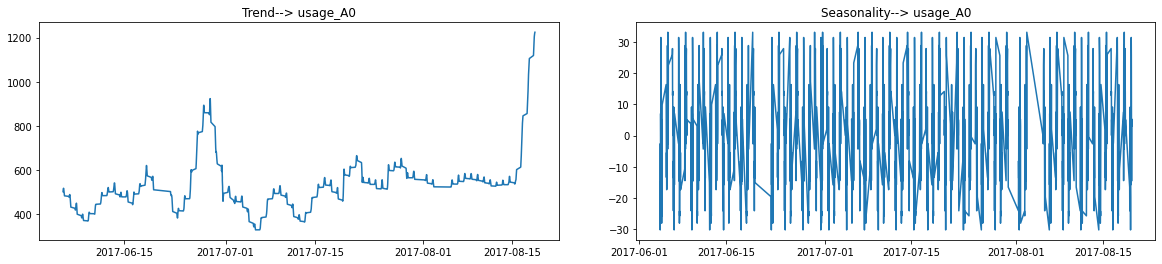

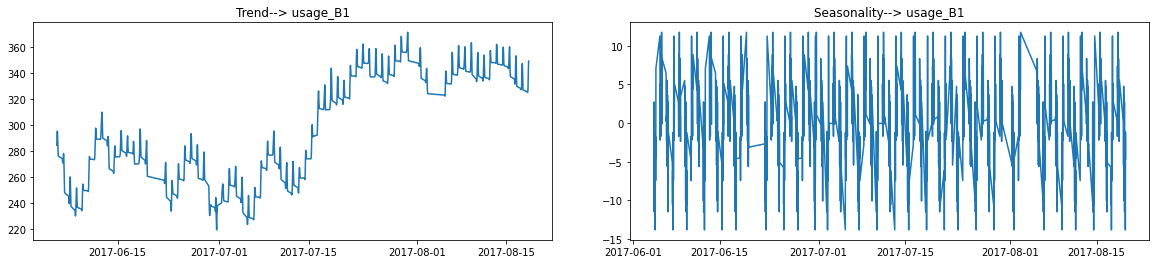

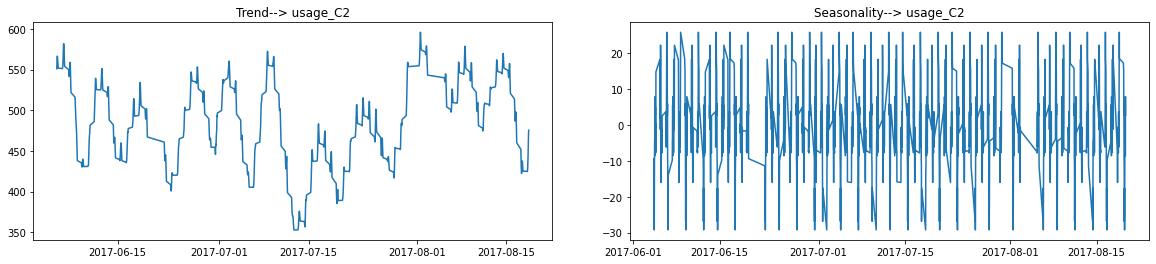

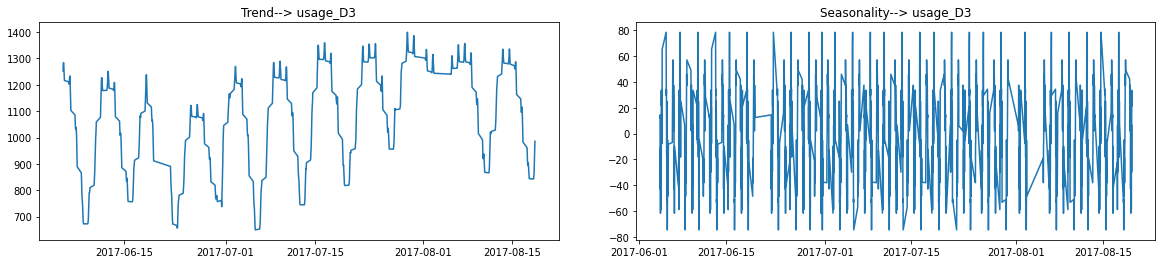

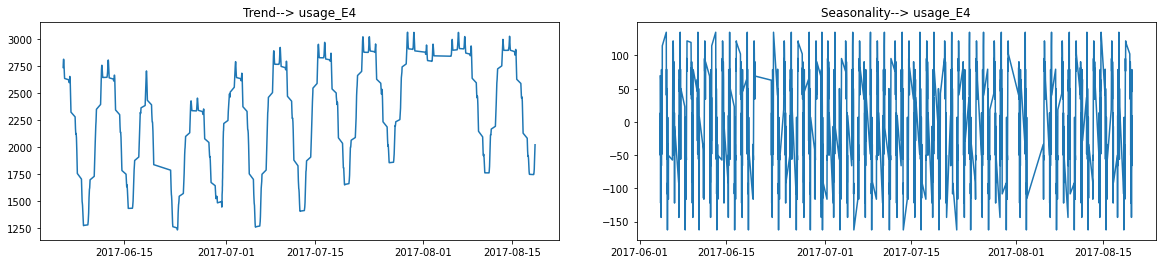

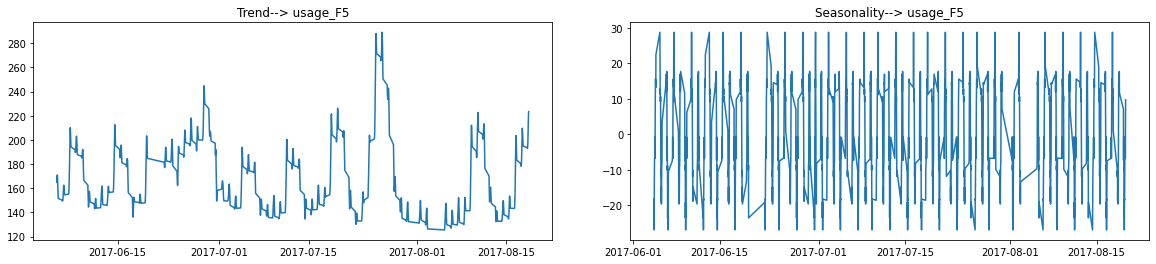

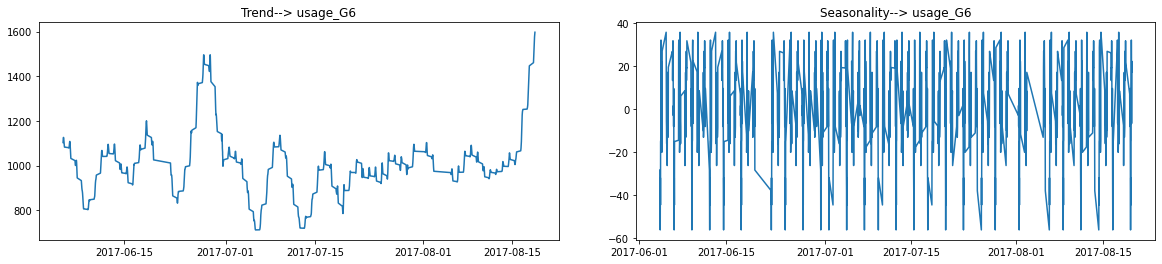

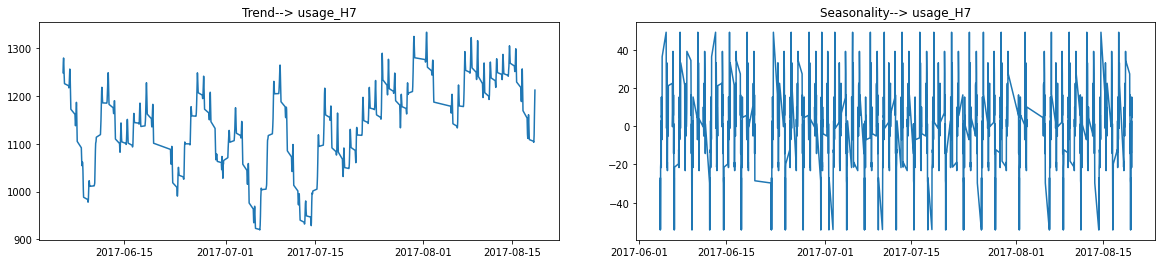

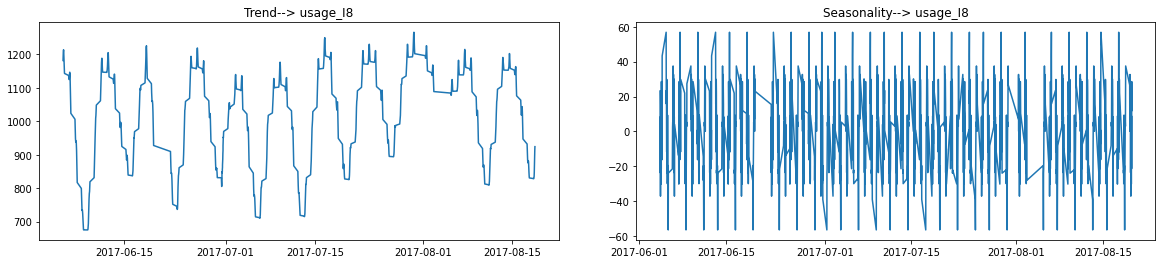

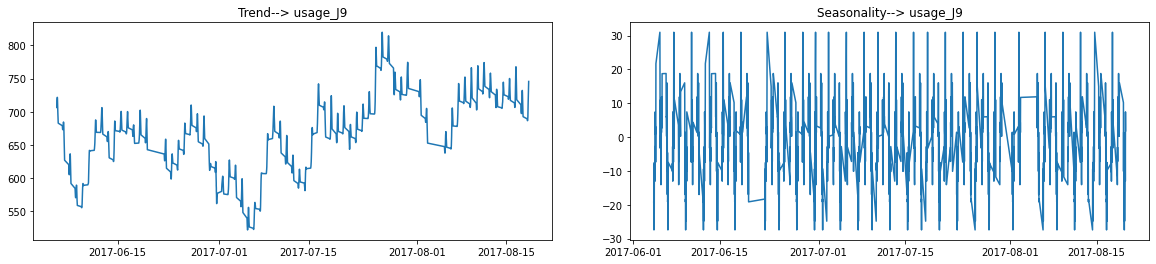

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
usage_cols = ['usage_A0', 'usage_B1', 'usage_C2', 'usage_D3', 'usage_E4', 'usage_F5', 'usage_G6', 'usage_H7', 'usage_I8', 'usage_J9']
for i in usage_cols:
    #print(i)
    try:
        decomposition = seasonal_decompose(df[i], model="additive", period=48)
    except Exception as e:
        print(e)
        pass
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,4), constrained_layout=False)
    fig.subplots_adjust(wspace=0.15)

    ax1= plt.subplot(121)
    ax1.plot(decomposition.trend)
    ax1.set_title("Trend--> "+i+"")

    ax2 = plt.subplot(122)
    ax2.plot(decomposition.seasonal)
    ax2.set_title("Seasonality--> "+i+"")

In [13]:
#Now lets analyze the stationarity of time series :
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

#Adfuller test
#null hypothesis : Series has a unit root 
#True ---> Stationary
#False ---> Non-stationary 

def TestStationaryAdfuller(ts, cutoff=0.05):
    ts_test = adfuller(ts, autolag='AIC')
    ts_test_output = pd.Series(ts_test[0:4], index = ['Test Stats', 'p-value', '#Lags Used', 'Number of observation used'])
    
    for k, v in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%k] = v
        
    
    if ts_test[1] <= cutoff:
        #print("ADF TEST :  Weak evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
        return True
    else:
        #print("ADF TEST :  Strong evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")
        return False

#KPSS test 
#null hyposthesis : Series is trend stationary 

from statsmodels.tsa.stattools import kpss

def testKPSStationary(timeseries, cutoff=0.05):
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
 
    if kpsstest[1] <= cutoff:
        #print("KPSS TEST : Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")
        return False
    else:
        #print("KPSS TEST : Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
        return True

def isStationary(timeseries, station):
    
    Station = station
    adf_result = TestStationaryAdfuller(timeseries)
    kpss_result = testKPSStationary(timeseries)
    
    if (adf_result==False and kpss_result==True):
        Type = 'Trend'
        Stationary = 'No'
    elif(adf_result==True and kpss_result==True):
        Type = np.NaN
        Stationary = 'Yes'
    elif(adf_result==True and kpss_result==False):
        Type = 'Difference'
        Stationary = 'No'
    else:
        Type = np.NaN
        Stationary = 'No'
    
    return pd.DataFrame([{'Station':station, 'Adfuller_result':adf_result, 'KPSS_result':kpss_result, 'Type':Type, 'Stationary':Stationary}])
    

In [14]:
# Apply the defined functions
stationary_df = pd.DataFrame(columns=['Station','Adfuller_result', 'KPSS_result', 'Type','Stationary'])
for i in usage_cols:
    try:
        stationary_df = stationary_df.append(isStationary(df[i], i))
    except Exception as e:
        print("This series of __"+i+"__ contains nans, will see it later(NaN at the start of the series we can safely drop it)")
print(stationary_df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning

    Station Adfuller_result KPSS_result        Type Stationary
0  usage_A0           False       False         NaN         No
0  usage_B1           False       False         NaN         No
0  usage_C2            True        True         NaN        Yes
0  usage_D3            True       False  Difference         No
0  usage_E4            True       False  Difference         No
0  usage_F5            True        True         NaN        Yes
0  usage_G6            True        True         NaN        Yes
0  usage_H7            True       False  Difference         No
0  usage_I8            True        True         NaN        Yes
0  usage_J9            True       False  Difference         No


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


 * `usage_B1` and `usage_I9` are not stationary should be fixed if we going to use ARIM

In [15]:
# Check for each column how many difference does 
for i in usage_cols:
    for diff_order in range(1,13):
        d = isStationary((df[i] - df[i].shift(diff_order)).dropna(), i)
        if d.Stationary.values == 'Yes':
            print(i, diff_order)
            break

usage_A0 1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


usage_B1 1
usage_C2 1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


usage_D3 1
usage_E4 1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


usage_F5 1
usage_G6 1
usage_H7 1
usage_I8 1
usage_J9 1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


All usage columns can be turned into stationary after 1 diffrence.

In [16]:
# Lets Make it all Stationary

df_stationary = df.diff()[1:]

from statsmodels.tsa.stattools import adfuller
for i in usage_cols:
  result = adfuller(df_stationary[i])
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.640418
p-value: 0.000000
Critical Values:
ADF Statistic: -11.539706
p-value: 0.000000
Critical Values:
ADF Statistic: -10.546440
p-value: 0.000000
Critical Values:
ADF Statistic: -8.416112
p-value: 0.000000
Critical Values:
ADF Statistic: -7.448997
p-value: 0.000000
Critical Values:
ADF Statistic: -12.117919
p-value: 0.000000
Critical Values:
ADF Statistic: -10.621982
p-value: 0.000000
Critical Values:
ADF Statistic: -11.590828
p-value: 0.000000
Critical Values:
ADF Statistic: -7.441597
p-value: 0.000000
Critical Values:
ADF Statistic: -11.625664
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


 Now all usage features are stationary

In [17]:
# Split Data Train and Test
train = df[df.index < "2017-08-05" ]
test = df[df.index > "2017-08-05"]

In [18]:
# Define an Evaluation function
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, mean_absolute_error

def evaluate_preds(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred) # mean squarred error
  mape = mean_absolute_percentage_error(y_true, y_pred) # mean absolute error
  mae = mean_absolute_error(y_true, y_pred) # mean absolute error
  rmse = np.sqrt(mse) # root mean squarred error
  return {"MSE": np.round(mse,2),
          "MAPE": np.round(mape,2),
          "MAE": np.round(mae,2),
          "RMSE": np.round(rmse,2)}

### Model_0: Naive Forecast
One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.




********************************************usage_A0*********************************************************


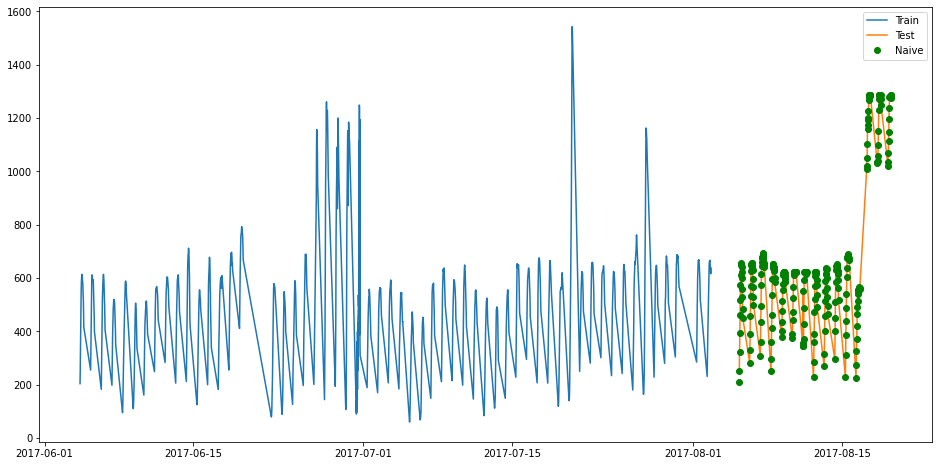

--------------------------------------- Evaluation metrics-usage_A0 ---------------------------------------------
{'MSE': 6014.18, 'MAPE': 0.09, 'MAE': 39.51, 'RMSE': 77.55}



********************************************usage_B1*********************************************************


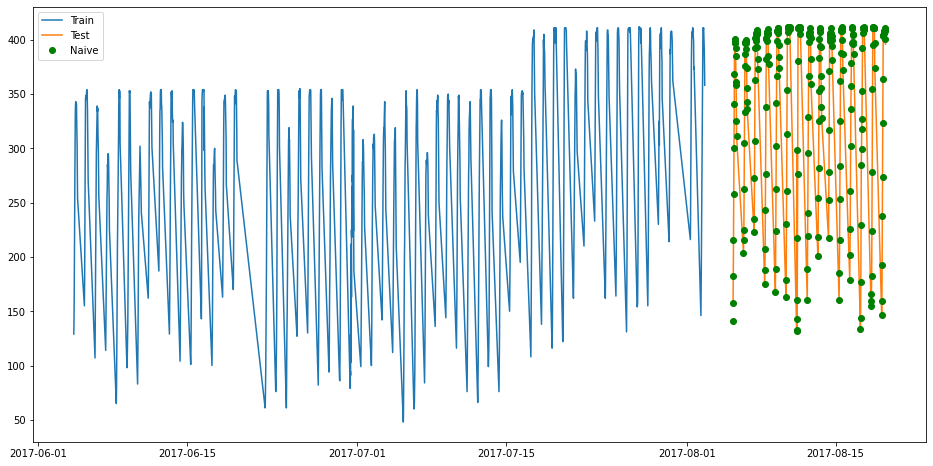

--------------------------------------- Evaluation metrics-usage_B1 ---------------------------------------------
{'MSE': 2986.71, 'MAPE': 0.12, 'MAE': 27.56, 'RMSE': 54.65}



********************************************usage_C2*********************************************************


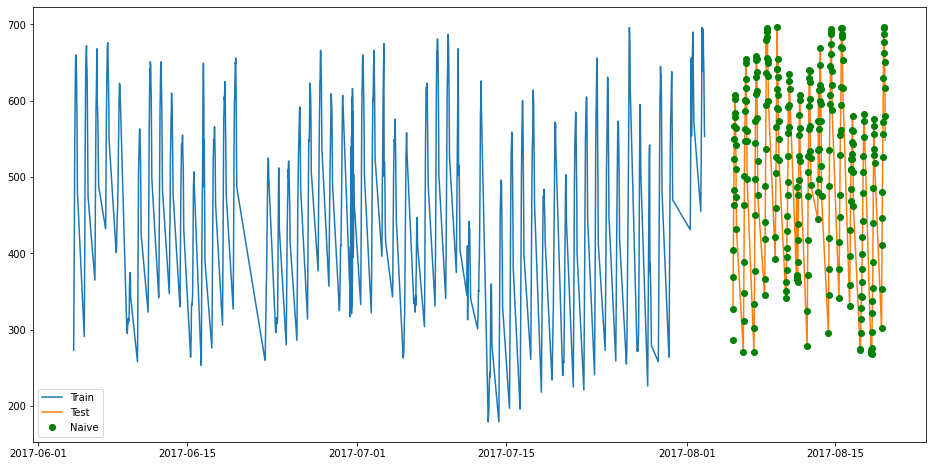

--------------------------------------- Evaluation metrics-usage_C2 ---------------------------------------------
{'MSE': 3473.37, 'MAPE': 0.09, 'MAE': 37.66, 'RMSE': 58.94}



********************************************usage_D3*********************************************************


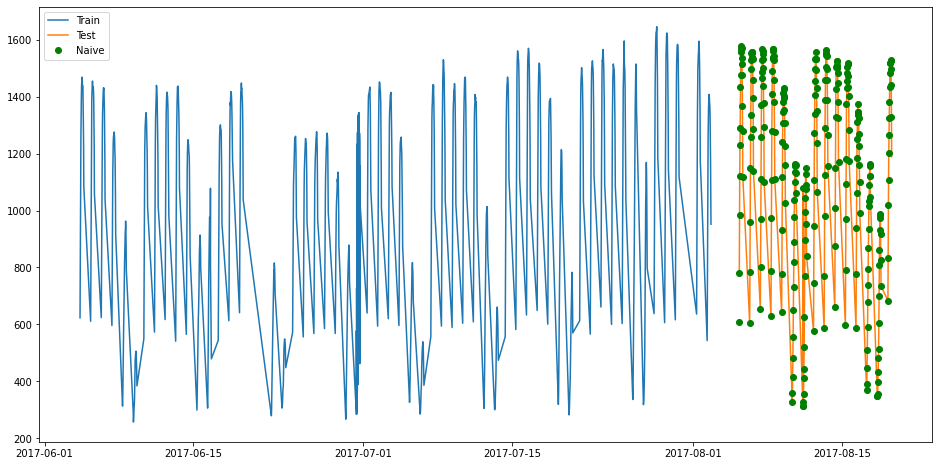

--------------------------------------- Evaluation metrics-usage_D3 ---------------------------------------------
{'MSE': 27397.13, 'MAPE': 0.14, 'MAE': 101.18, 'RMSE': 165.52}



********************************************usage_E4*********************************************************


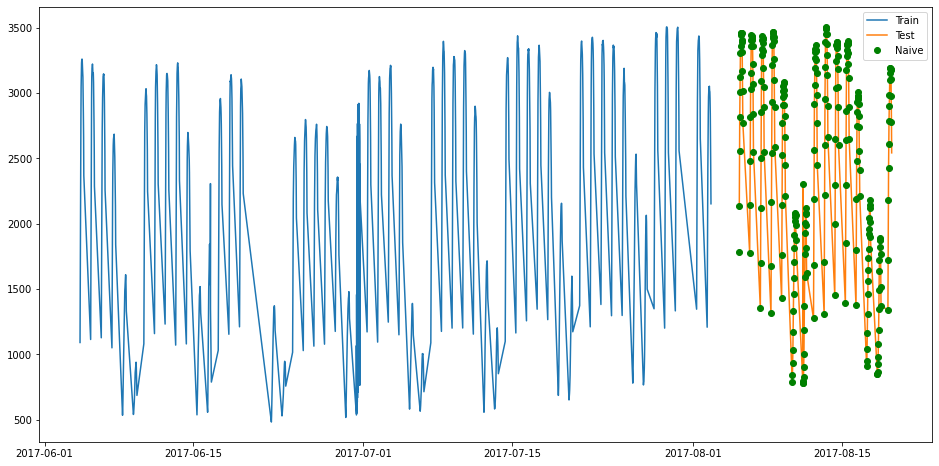

--------------------------------------- Evaluation metrics-usage_E4 ---------------------------------------------
{'MSE': 116781.97, 'MAPE': 0.12, 'MAE': 202.63, 'RMSE': 341.73}



********************************************usage_F5*********************************************************


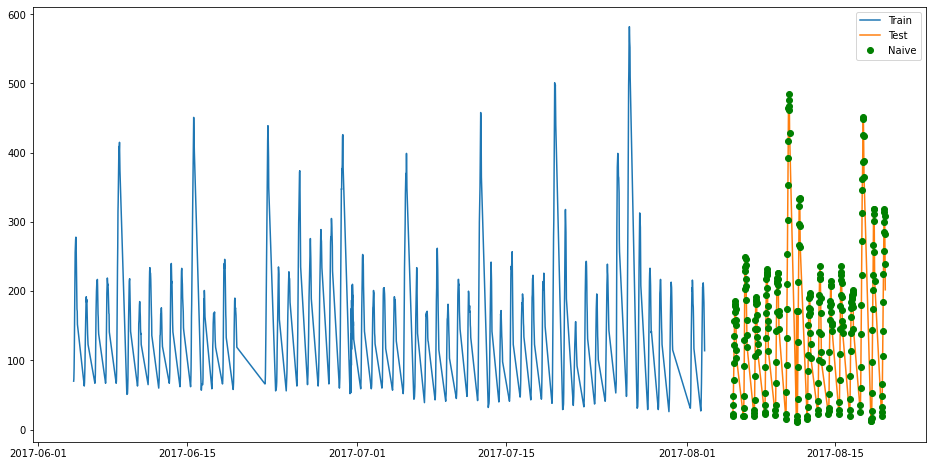

--------------------------------------- Evaluation metrics-usage_F5 ---------------------------------------------
{'MSE': 2661.11, 'MAPE': 0.71, 'MAE': 28.94, 'RMSE': 51.59}



********************************************usage_G6*********************************************************


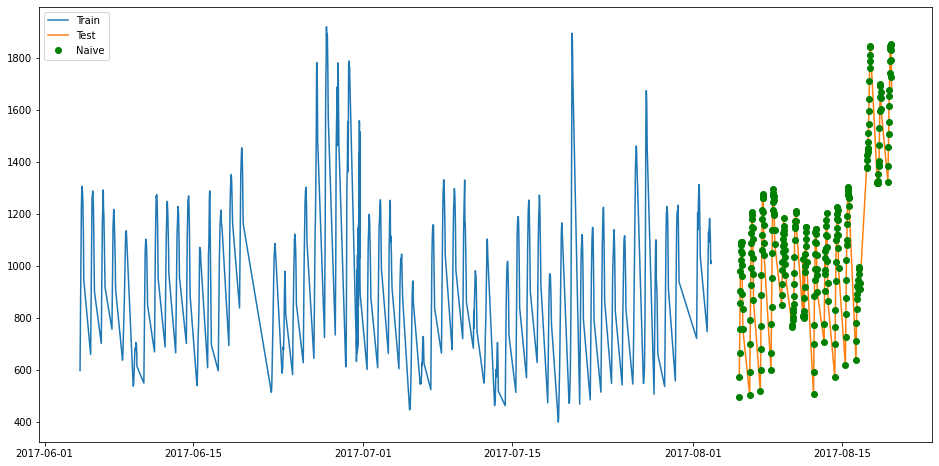

--------------------------------------- Evaluation metrics-usage_G6 ---------------------------------------------
{'MSE': 10660.43, 'MAPE': 0.07, 'MAE': 62.22, 'RMSE': 103.25}



********************************************usage_H7*********************************************************


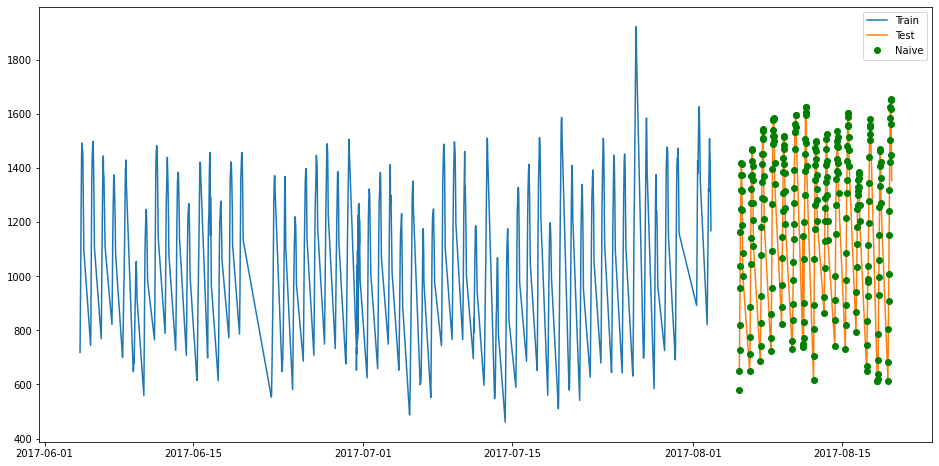

--------------------------------------- Evaluation metrics-usage_H7 ---------------------------------------------
{'MSE': 24786.65, 'MAPE': 0.1, 'MAE': 93.97, 'RMSE': 157.44}



********************************************usage_I8*********************************************************


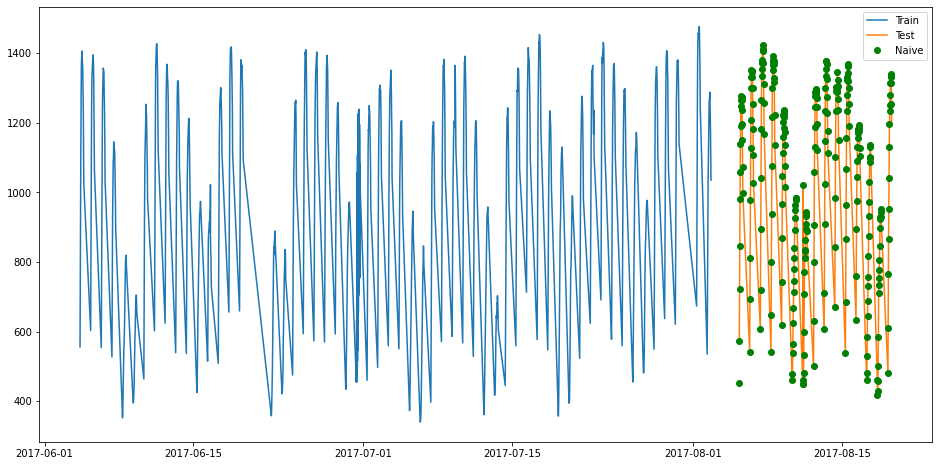

--------------------------------------- Evaluation metrics-usage_I8 ---------------------------------------------
{'MSE': 21856.44, 'MAPE': 0.11, 'MAE': 81.32, 'RMSE': 147.84}



********************************************usage_J9*********************************************************


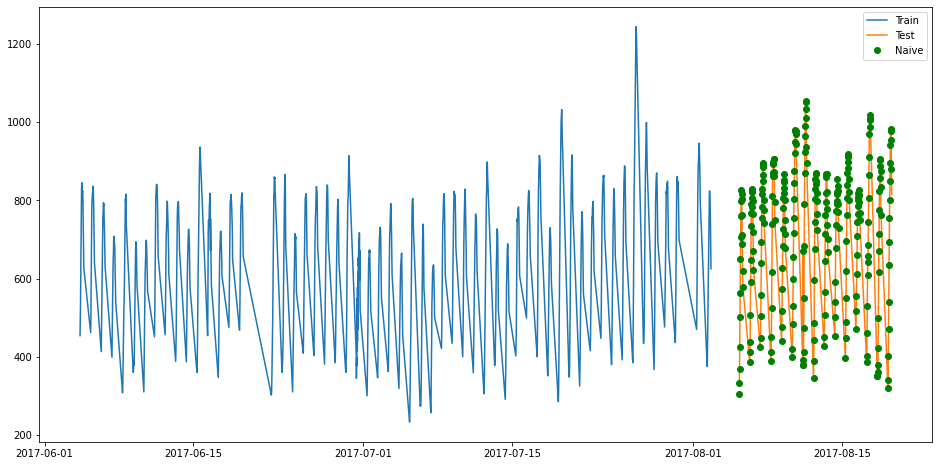

--------------------------------------- Evaluation metrics-usage_J9 ---------------------------------------------
{'MSE': 10441.65, 'MAPE': 0.11, 'MAE': 57.98, 'RMSE': 102.18}


In [19]:
# Naive forecast
naive_dict = {}
predictions = test.copy()
for i in usage_cols:
    print('\n\n')
    print("********************************************"+ i +"*********************************************************")
    # Predict
    predictions['Naive'] = test[i][:-1]

    # Plot
    plt.figure(figsize=(16,8))
    plt.plot(train[i], label='Train')
    plt.plot(test[i][1:], label='Test')
    plt.plot(predictions['Naive'], "go", label='Naive')
    plt.legend(loc='best')
    plt.show()
    print(f"--------------------------------------- Evaluation metrics-{i} ---------------------------------------------")
    # Evaluation
    eval_results = evaluate_preds(test[i][1:], predictions['Naive'][:-1])
    naive_dict[i] = eval_results
    print(eval_results)


In [20]:
# Lets check Evaluation Results for Naive Forecasts
naive_results = pd.DataFrame(naive_dict)
naive_results

usage_A0  usage_B1  usage_C2  usage_D3   usage_E4  usage_F5  usage_G6  \
MSE    6014.18   2986.71   3473.37  27397.13  116781.97   2661.11  10660.43   
MAPE      0.09      0.12      0.09      0.14       0.12      0.71      0.07   
MAE      39.51     27.56     37.66    101.18     202.63     28.94     62.22   
RMSE     77.55     54.65     58.94    165.52     341.73     51.59    103.25   

      usage_H7  usage_I8  usage_J9  
MSE   24786.65  21856.44  10441.65  
MAPE      0.10      0.11      0.11  
MAE      93.97     81.32     57.98  
RMSE    157.44    147.84    102.18

### Model_1: XGBoost

In [21]:
# Lets make univariate time series multivariate
def create_features(df, target_label=None):
    """
    Creates time series features from datetime index
    """
    df_func = df.copy()
    df_func['date'] = df_func.index
    df_func['hour'] = df_func['date'].dt.hour
    df_func['dayofweek'] = df_func['date'].dt.dayofweek
    df_func['quarter'] = df_func['date'].dt.quarter
    df_func['month'] = df_func['date'].dt.month
    df_func['year'] = df_func['date'].dt.year
    df_func['dayofyear'] = df_func['date'].dt.dayofyear
    df_func['dayofmonth'] = df_func['date'].dt.day
    df_func['weekofyear'] = df_func['date'].dt.weekofyear
    
    current_regex = target_label[-2:]
    X = df_func[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear',f'total_capacity_{current_regex}']]#
           
    if target_label:
        y = df[target_label]
        del(df_func)
        return X, y
        del(df_func)
    return X




********************************************usage_A0*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


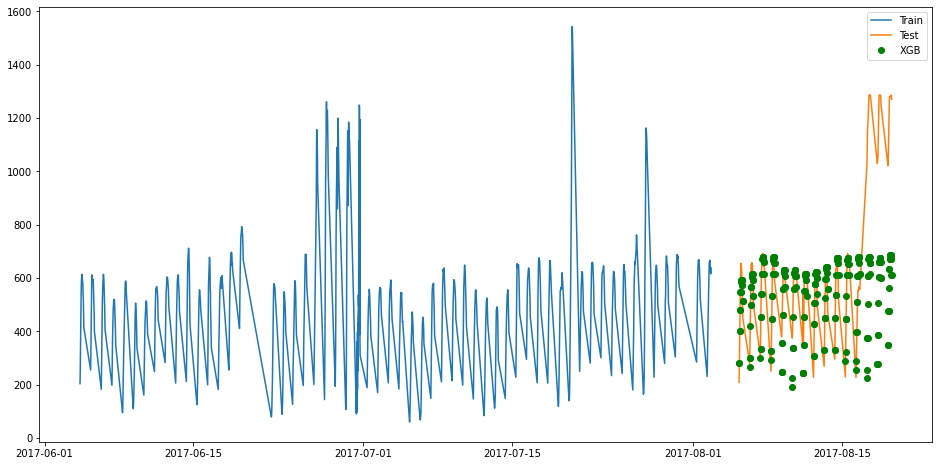

--------------------------------------- Evaluation metrics-usage_A0 ---------------------------------------------
{'MSE': 87773.22, 'MAPE': 0.19, 'MAE': 167.85, 'RMSE': 296.27}



********************************************usage_B1*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


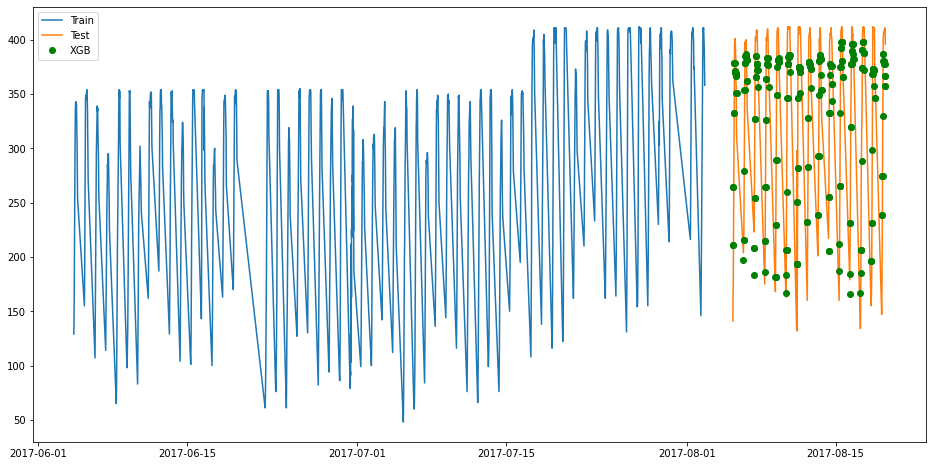

--------------------------------------- Evaluation metrics-usage_B1 ---------------------------------------------
{'MSE': 1354.89, 'MAPE': 0.1, 'MAE': 30.41, 'RMSE': 36.81}



********************************************usage_C2*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


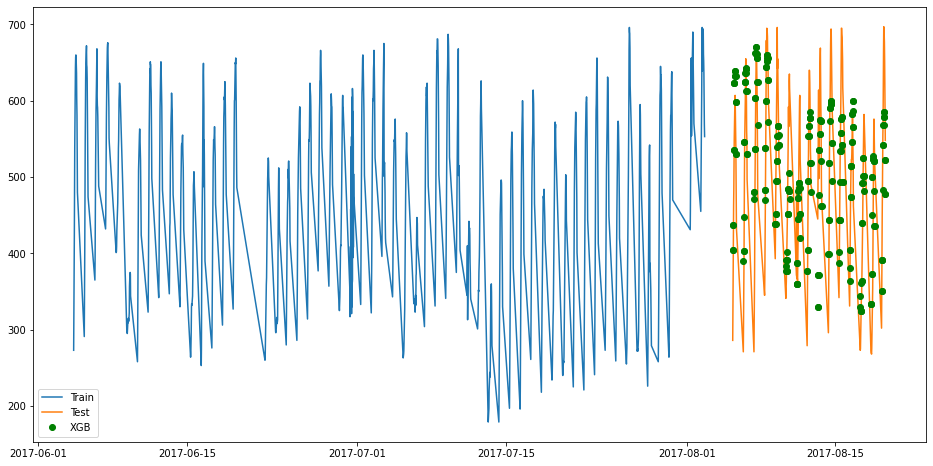

--------------------------------------- Evaluation metrics-usage_C2 ---------------------------------------------
{'MSE': 5645.73, 'MAPE': 0.13, 'MAE': 60.03, 'RMSE': 75.14}



********************************************usage_D3*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


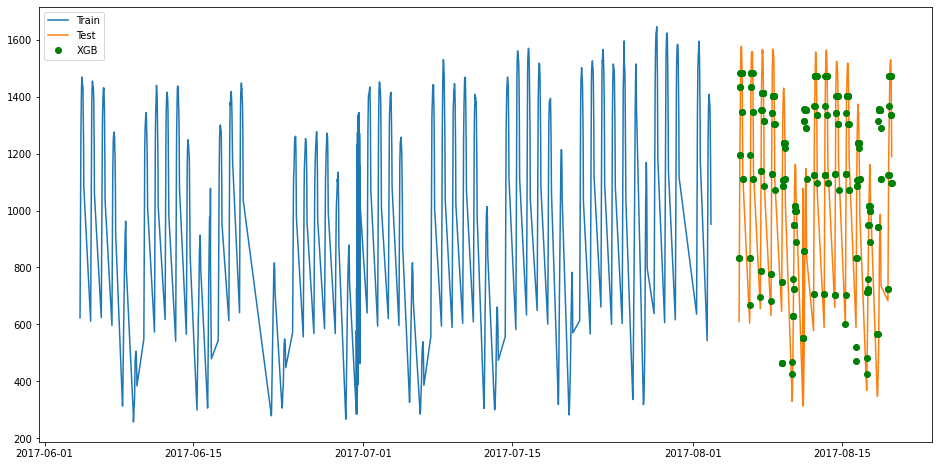

--------------------------------------- Evaluation metrics-usage_D3 ---------------------------------------------
{'MSE': 45483.82, 'MAPE': 0.18, 'MAE': 146.94, 'RMSE': 213.27}



********************************************usage_E4*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


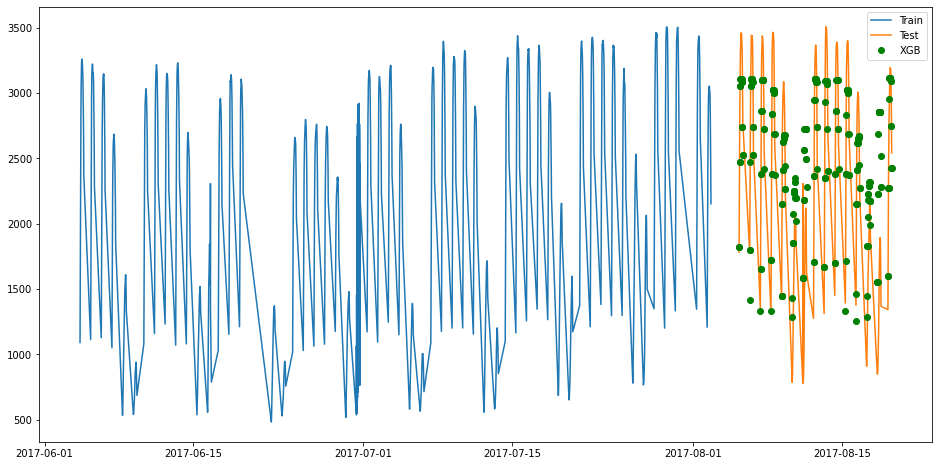

--------------------------------------- Evaluation metrics-usage_E4 ---------------------------------------------
{'MSE': 252657.19, 'MAPE': 0.22, 'MAE': 392.09, 'RMSE': 502.65}



********************************************usage_F5*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


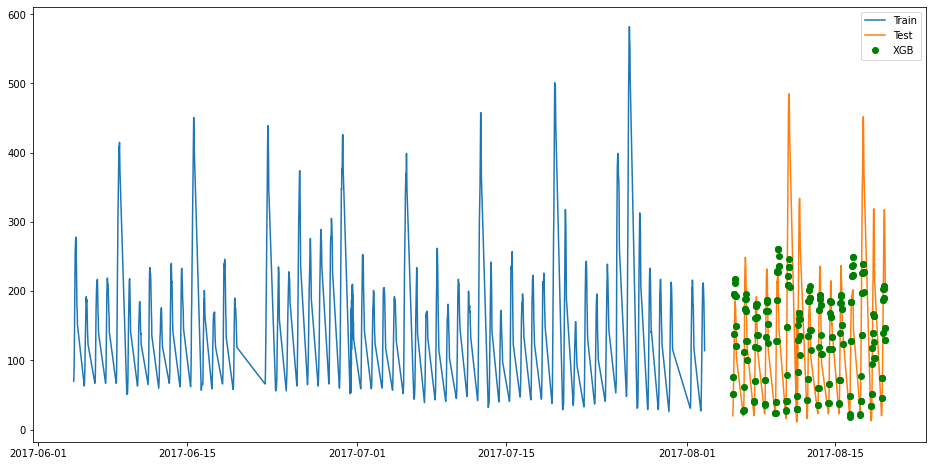

--------------------------------------- Evaluation metrics-usage_F5 ---------------------------------------------
{'MSE': 5529.99, 'MAPE': 0.36, 'MAE': 49.01, 'RMSE': 74.36}



********************************************usage_G6*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


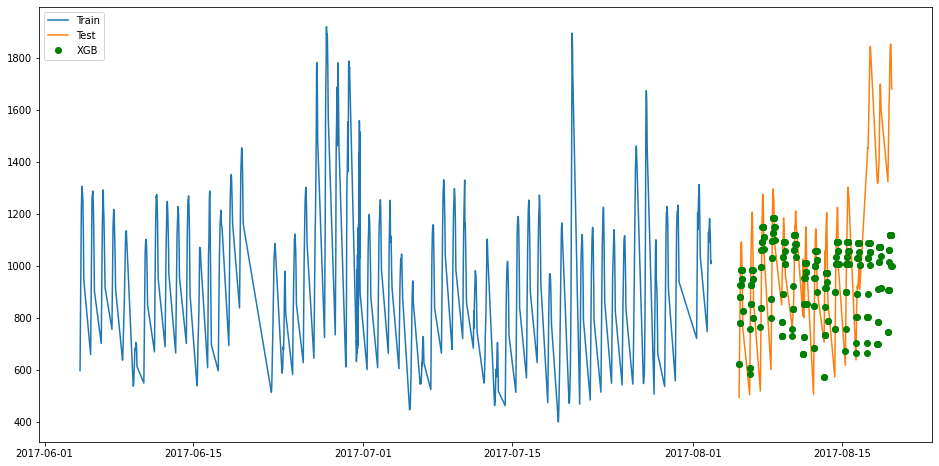

--------------------------------------- Evaluation metrics-usage_G6 ---------------------------------------------
{'MSE': 87219.5, 'MAPE': 0.16, 'MAE': 200.29, 'RMSE': 295.33}



********************************************usage_H7*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


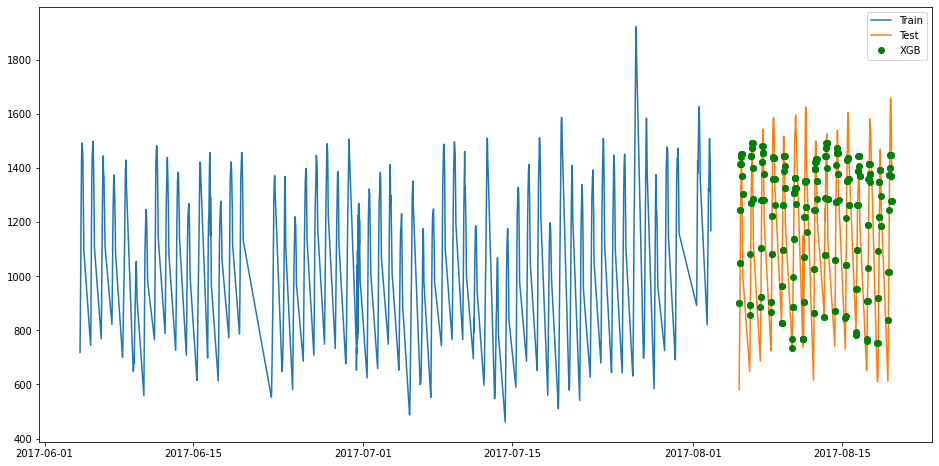

--------------------------------------- Evaluation metrics-usage_H7 ---------------------------------------------
{'MSE': 18964.99, 'MAPE': 0.1, 'MAE': 111.84, 'RMSE': 137.71}



********************************************usage_I8*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


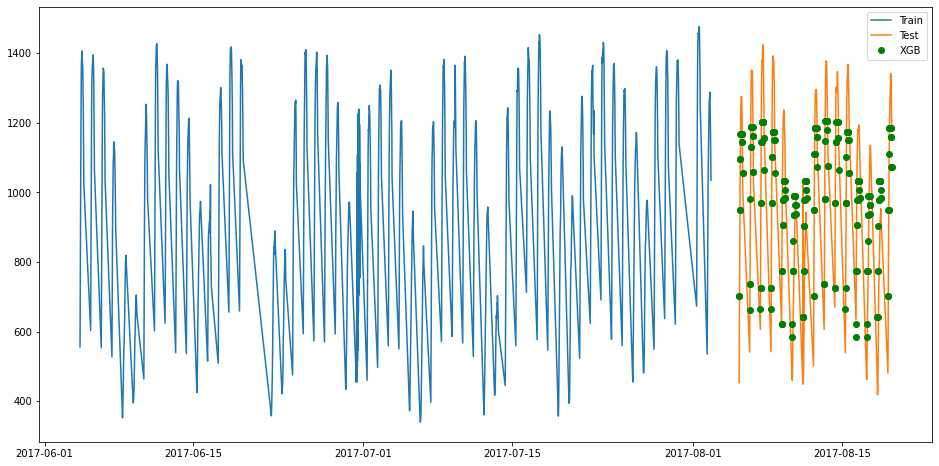

--------------------------------------- Evaluation metrics-usage_I8 ---------------------------------------------
{'MSE': 22167.1, 'MAPE': 0.15, 'MAE': 131.39, 'RMSE': 148.89}



********************************************usage_J9*********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits


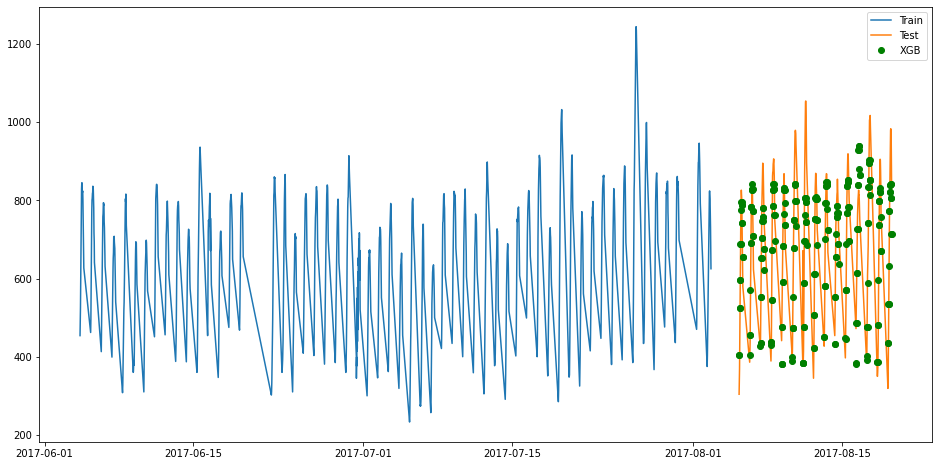

--------------------------------------- Evaluation metrics-usage_J9 ---------------------------------------------
{'MSE': 7828.33, 'MAPE': 0.1, 'MAE': 70.37, 'RMSE': 88.48}


In [22]:
# XGBOOST
from sklearn.model_selection import RandomizedSearchCV
import random
import xgboost as xgb
xgb_dict = {}
params = {
            "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
            "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
            }

for i in usage_cols:
  print('\n\n')
  print("********************************************"+ i +"*********************************************************")
  # Split data to train test and add time features
  X_train, y_train = create_features(train, target_label=f'{i}')
  X_test, y_test = create_features(test, target_label=f'{i}')
  # XGBoost with optimization
  reg = xgb.XGBRegressor(objective="reg:squarederror")
  rs_model=RandomizedSearchCV(reg,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
  
  rs_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=50,
              verbose=False)
  
  predictions['XGB_preds'] = rs_model.best_estimator_.predict(X_test)
  plt.figure(figsize=(16,8))
  plt.plot(train[i], label='Train')
  plt.plot(y_test, label='Test')
  plt.plot(test.index, predictions["XGB_preds"], "go", label='XGB')
  plt.legend(loc='best')
  plt.show()
  print(f"--------------------------------------- Evaluation metrics-{i} ---------------------------------------------")
  eval_results = evaluate_preds(y_test, predictions["XGB_preds"])
  xgb_dict[i] = eval_results
  print(eval_results)



In [23]:
# Lets check XGboost results
xgb_results = pd.DataFrame(xgb_dict)
xgb_results

usage_A0  usage_B1  usage_C2  usage_D3   usage_E4  usage_F5  usage_G6  \
MSE   87773.22   1354.89   5645.73  45483.82  252657.19   5529.99  87219.50   
MAPE      0.19      0.10      0.13      0.18       0.22      0.36      0.16   
MAE     167.85     30.41     60.03    146.94     392.09     49.01    200.29   
RMSE    296.27     36.81     75.14    213.27     502.65     74.36    295.33   

      usage_H7  usage_I8  usage_J9  
MSE   18964.99  22167.10   7828.33  
MAPE      0.10      0.15      0.10  
MAE     111.84    131.39     70.37  
RMSE    137.71    148.89     88.48

In [24]:
# What was Naive model results
naive_results

usage_A0  usage_B1  usage_C2  usage_D3   usage_E4  usage_F5  usage_G6  \
MSE    6014.18   2986.71   3473.37  27397.13  116781.97   2661.11  10660.43   
MAPE      0.09      0.12      0.09      0.14       0.12      0.71      0.07   
MAE      39.51     27.56     37.66    101.18     202.63     28.94     62.22   
RMSE     77.55     54.65     58.94    165.52     341.73     51.59    103.25   

      usage_H7  usage_I8  usage_J9  
MSE   24786.65  21856.44  10441.65  
MAPE      0.10      0.11      0.11  
MAE      93.97     81.32     57.98  
RMSE    157.44    147.84    102.18

### Model_2: LGBM 

In [25]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-k3nnfdlw
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-k3nnfdlw
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=e30a877beccafd80f32af858799e6d75bdfcc24242e634eb14feb95a04c7f131
  Stored in directory: /tmp/pip-ephem-wheel-cache-ymcg9zlm/wheels/d6/9e/e3/8818f5597f06caa60393811f8aa57eb87b8565d772046d1b72
Successfully built scikit-optimize





********************************************usage_A0*********************************************************


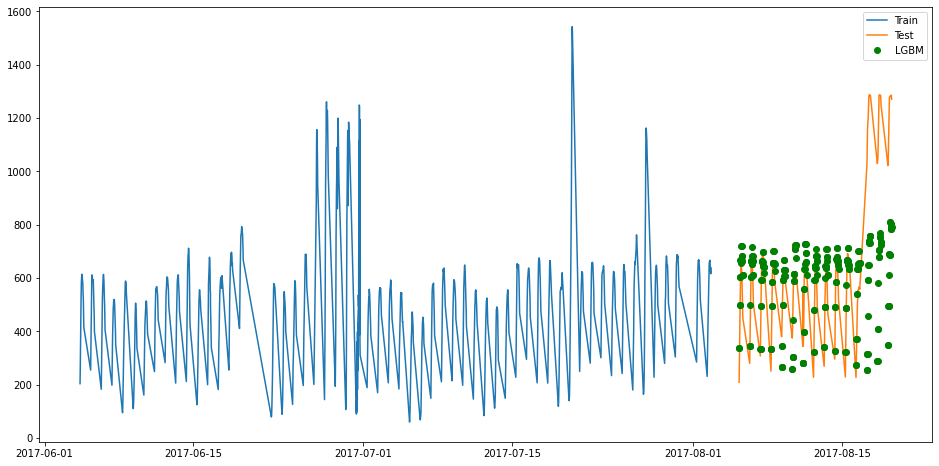

--------------------------------------- Evaluation metrics-usage_A0 ---------------------------------------------
{'MSE': 77212.6, 'MAPE': 0.2, 'MAE': 168.29, 'RMSE': 277.87}



********************************************usage_B1*********************************************************


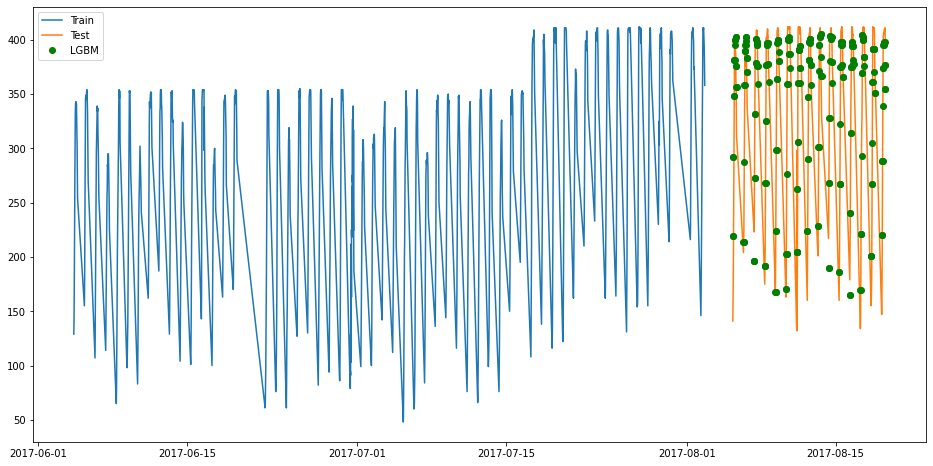

--------------------------------------- Evaluation metrics-usage_B1 ---------------------------------------------
{'MSE': 1189.42, 'MAPE': 0.09, 'MAE': 26.03, 'RMSE': 34.49}



********************************************usage_C2*********************************************************


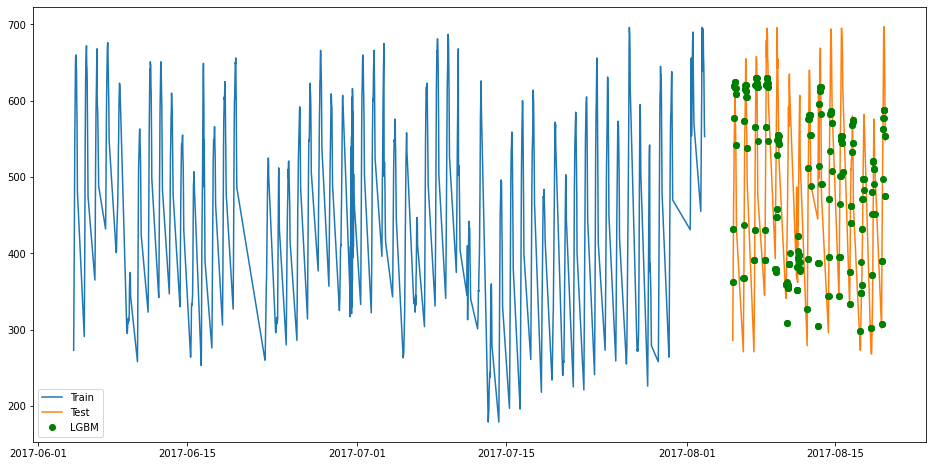

--------------------------------------- Evaluation metrics-usage_C2 ---------------------------------------------
{'MSE': 7035.1, 'MAPE': 0.13, 'MAE': 64.08, 'RMSE': 83.88}



********************************************usage_D3*********************************************************


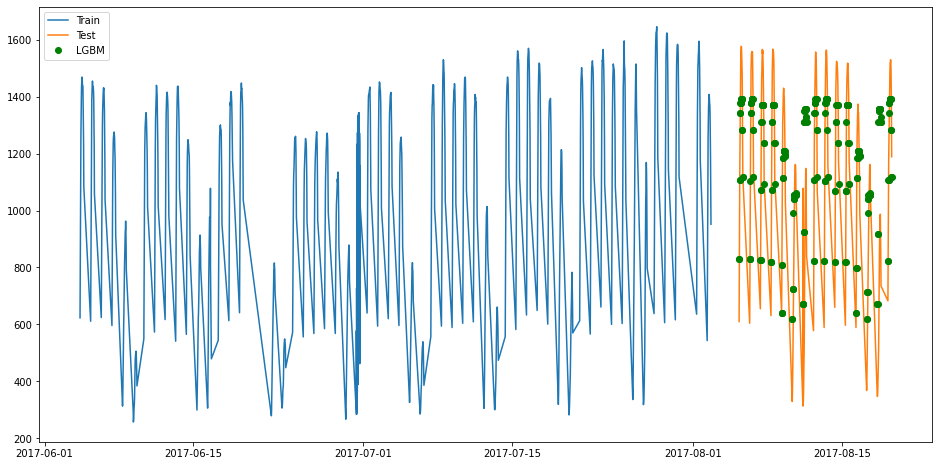

--------------------------------------- Evaluation metrics-usage_D3 ---------------------------------------------
{'MSE': 54102.6, 'MAPE': 0.22, 'MAE': 174.99, 'RMSE': 232.6}



********************************************usage_E4*********************************************************


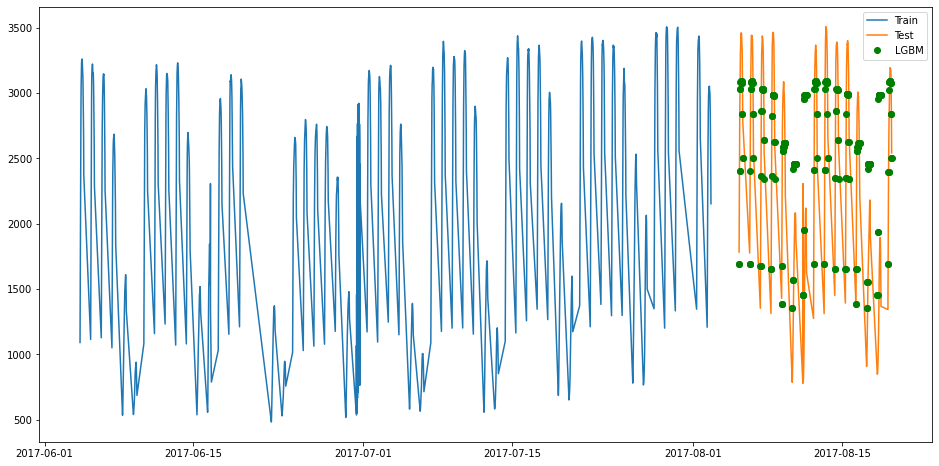

--------------------------------------- Evaluation metrics-usage_E4 ---------------------------------------------
{'MSE': 339377.15, 'MAPE': 0.25, 'MAE': 453.54, 'RMSE': 582.56}



********************************************usage_F5*********************************************************


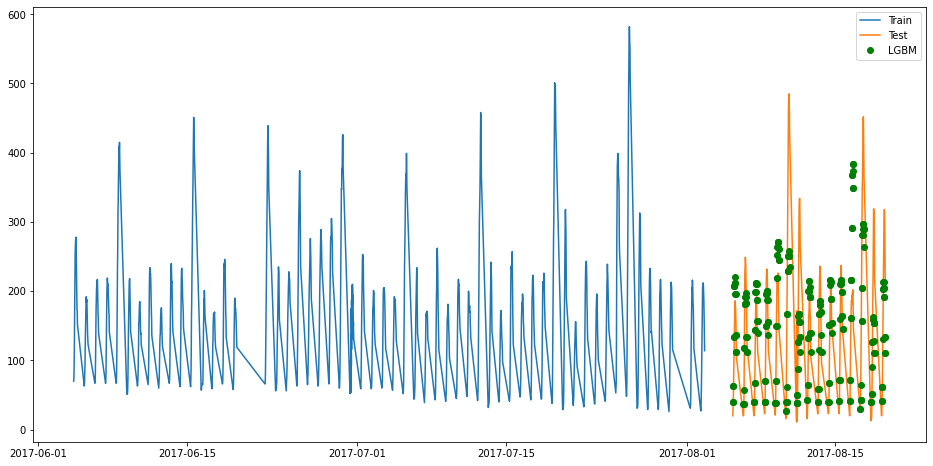

--------------------------------------- Evaluation metrics-usage_F5 ---------------------------------------------
{'MSE': 5671.32, 'MAPE': 0.4, 'MAE': 51.37, 'RMSE': 75.31}



********************************************usage_G6*********************************************************


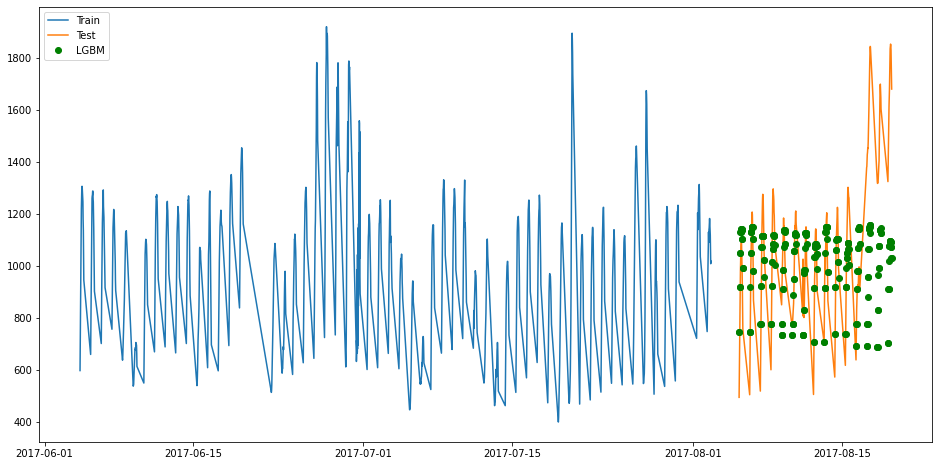

--------------------------------------- Evaluation metrics-usage_G6 ---------------------------------------------
{'MSE': 81486.93, 'MAPE': 0.16, 'MAE': 193.94, 'RMSE': 285.46}



********************************************usage_H7*********************************************************


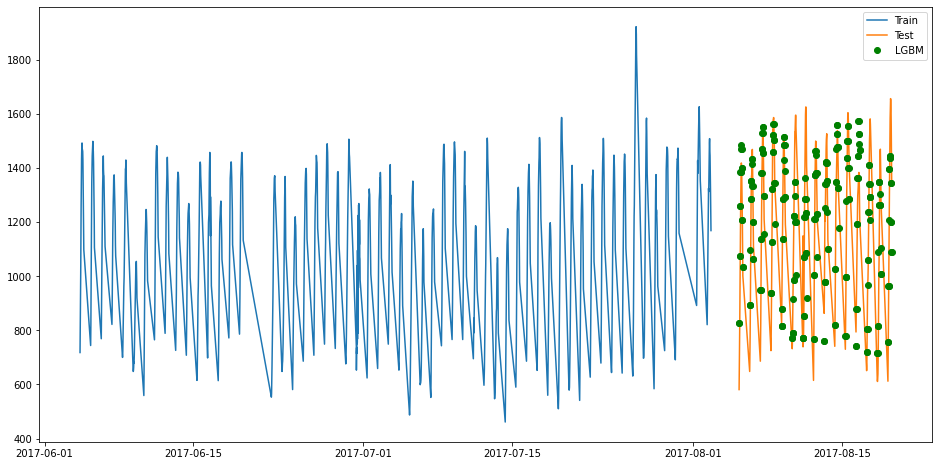

--------------------------------------- Evaluation metrics-usage_H7 ---------------------------------------------
{'MSE': 26416.4, 'MAPE': 0.11, 'MAE': 124.62, 'RMSE': 162.53}



********************************************usage_I8*********************************************************


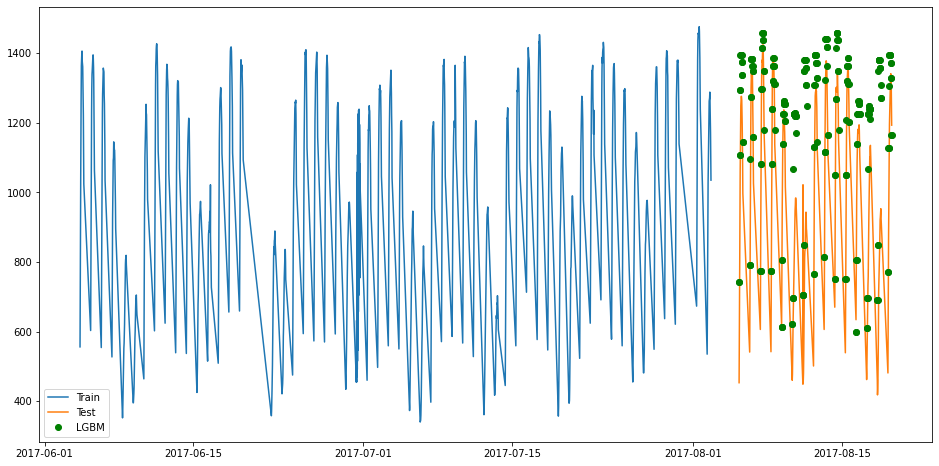

--------------------------------------- Evaluation metrics-usage_I8 ---------------------------------------------
{'MSE': 53889.74, 'MAPE': 0.21, 'MAE': 169.43, 'RMSE': 232.14}



********************************************usage_J9*********************************************************


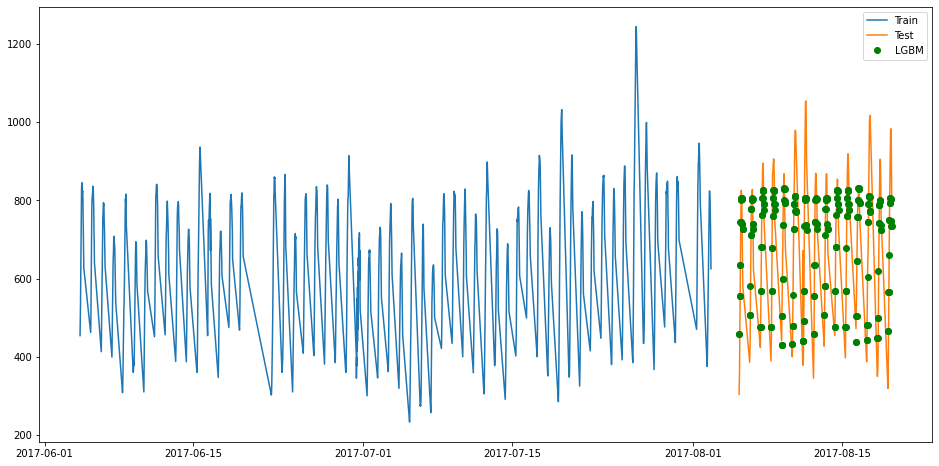

--------------------------------------- Evaluation metrics-usage_J9 ---------------------------------------------
{'MSE': 8196.66, 'MAPE': 0.1, 'MAE': 68.82, 'RMSE': 90.54}


In [26]:
# LGBM
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from lightgbm import LGBMRegressor
lgbm_dict = {}
lgbm_opt = BayesSearchCV(
    LGBMRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(-1, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)
for i in usage_cols:
  print('\n\n')
  print("********************************************"+ i +"*********************************************************")
  # Split data to train test and add time features
  X_train, y_train = create_features(train, target_label=f'{i}')
  X_test, y_test = create_features(test, target_label=f'{i}')
  
  # Fit
  lgbm_opt.fit(X_train, y_train)
  # Predict
  predictions['LGBM_preds'] = lgbm_opt.best_estimator_.predict(X_test)
  

  #Plot
  plt.figure(figsize=(16,8))
  plt.plot(train[i], label='Train')
  plt.plot(y_test, label='Test')
  plt.plot(test.index, predictions["LGBM_preds"], "go", label='LGBM')
  plt.legend(loc='best')
  plt.show()
  print(f"--------------------------------------- Evaluation metrics-{i} ---------------------------------------------")
  # Evaluation
  eval_results = evaluate_preds(y_test, predictions["LGBM_preds"])
  lgbm_dict[i] = eval_results
  print(eval_results)


In [27]:
# Lets check LGBM results
lgbm_results = pd.DataFrame(lgbm_dict)
lgbm_results

usage_A0  usage_B1  usage_C2  usage_D3   usage_E4  usage_F5  usage_G6  \
MSE   77212.60   1189.42   7035.10  54102.60  339377.15   5671.32  81486.93   
MAPE      0.20      0.09      0.13      0.22       0.25      0.40      0.16   
MAE     168.29     26.03     64.08    174.99     453.54     51.37    193.94   
RMSE    277.87     34.49     83.88    232.60     582.56     75.31    285.46   

      usage_H7  usage_I8  usage_J9  
MSE   26416.40  53889.74   8196.66  
MAPE      0.11      0.21      0.10  
MAE     124.62    169.43     68.82  
RMSE    162.53    232.14     90.54

Those Naive results are hard to beat. Let's try Neural Network

### Model_3: Neural Network

In [28]:
#Inverse MinMaxScaler for series
def rev_min_max_func(scaled_val):
    max_val = max(test[f'{i}'])
    min_val = min(test[f'{i}'])
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val




********************************************usage_A0*********************************************************
Epoch 1/3
33/33 [==============================] - 7s 153ms/step - loss: 517.2623 - mae: 517.2623 - val_loss: 679.2091 - val_mae: 679.2091 - lr: 1.0000e-04
Epoch 2/3
33/33 [==============================] - 3s 103ms/step - loss: 517.1336 - mae: 517.1336 - val_loss: 678.9259 - val_mae: 678.9259 - lr: 1.1220e-04
Epoch 3/3
9/9 [==============================] - 0s 35ms/step


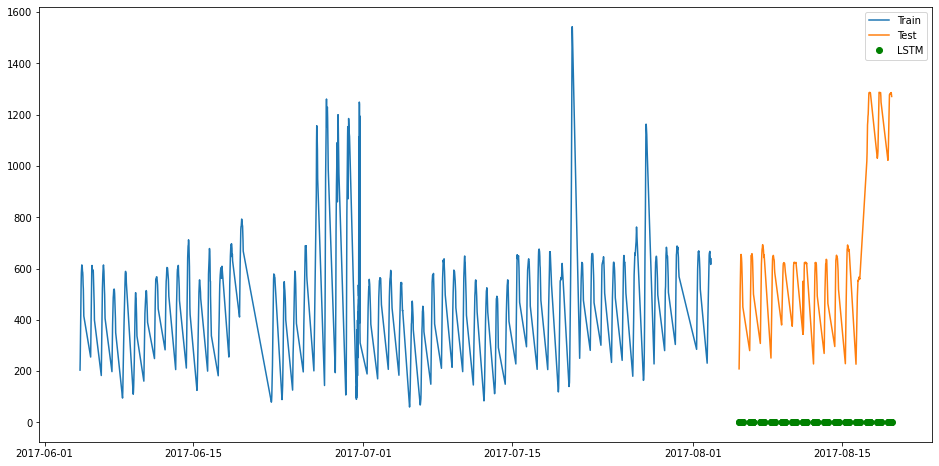

{'MSE': 542974.9, 'MAPE': 1.0, 'MAE': 677.69, 'RMSE': 736.87}



********************************************usage_B1*********************************************************
Epoch 1/3
33/33 [==============================] - 7s 162ms/step - loss: 286.3571 - mae: 286.3571 - val_loss: 343.0873 - val_mae: 343.0873 - lr: 1.0000e-04
Epoch 2/3
33/33 [==============================] - 3s 104ms/step - loss: 286.1546 - mae: 286.1546 - val_loss: 342.6383 - val_mae: 342.6383 - lr: 1.1220e-04
Epoch 3/3
9/9 [==============================] - 0s 35ms/step


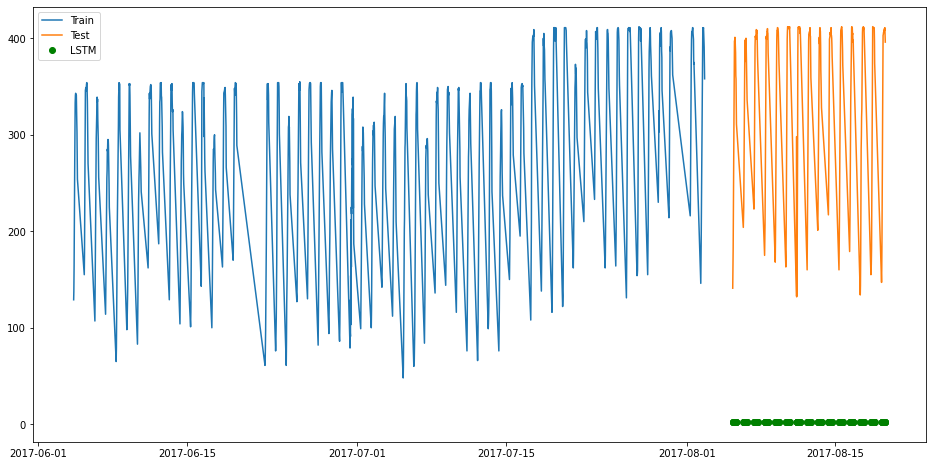

{'MSE': 123335.04, 'MAPE': 0.99, 'MAE': 340.89, 'RMSE': 351.19}



********************************************usage_C2*********************************************************
Epoch 1/3
33/33 [==============================] - 8s 159ms/step - loss: 480.0468 - mae: 480.0468 - val_loss: 513.5980 - val_mae: 513.5980 - lr: 1.0000e-04
Epoch 2/3
33/33 [==============================] - 3s 97ms/step - loss: 479.8563 - mae: 479.8563 - val_loss: 513.1709 - val_mae: 513.1709 - lr: 1.1220e-04
Epoch 3/3
9/9 [==============================] - 1s 75ms/step


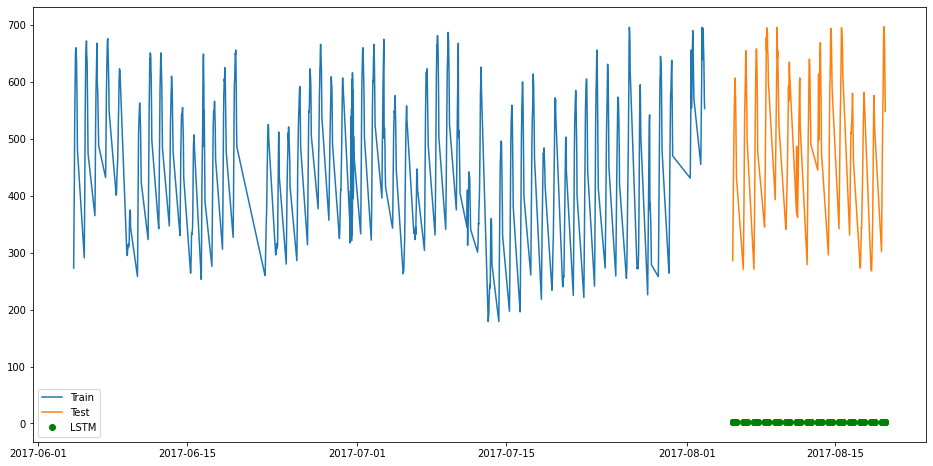

{'MSE': 274946.72, 'MAPE': 0.99, 'MAE': 511.2, 'RMSE': 524.35}



********************************************usage_D3*********************************************************
Epoch 1/3
11/33 [=========>....................] - ETA: 1s - loss: 1035.7419 - mae: 1035.7419

KeyboardInterrupt: ignored

In [32]:
# Lets build an ANN
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# For reprodcable code
tf.random.set_seed(42)

# Create LSTM dictionary for results
lstm_dict = {}

for i in usage_cols:
  tf.keras.backend.clear_session()

  print('\n\n')
  print("********************************************"+ i +"*********************************************************")
  # Split data to train test and add time features
  X_train, y_train = create_features(train, target_label=f'{i}')
  X_test, y_test = create_features(test, target_label=f'{i}')
  
  model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True,dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
  ],name = f"model_{i}")
  

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20))

  #Compile  
  model.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam() , metrics =["mae"])
  
  # Fit
  model.fit(X_train, y_train, 
            epochs=30,
            validation_data=(X_test, y_test),
            callbacks=[lr_schedule, 
                       #create_model_checkpoint(model_name=f"{i}" )
                       ]
           )
  

  
  # predict
  
  lstm_preds = tf.squeeze(model.predict(X_test))   
  
  # Plot
  plt.figure(figsize=(16,8))
  plt.plot(train[i], label='Train')
  plt.plot(test[i], label='Test')
  plt.plot(test.index, lstm_preds, "go", label='LSTM')
  plt.legend(loc='best')
  plt.show()

  # Evaluation 
  lstm_dict[i] = evaluate_preds(y_test, lstm_preds)
  print(lstm_dict[i])


In [ ]:
# Get LSTM results
lstm_results = pd.DataFrame(lstm_dict)
lstm_results

In [ ]:
# Get all results in one place
results = pd.concat([naive_results, xgb_results, lgbm_results, lstm_results],
                    axis = 0,
                    keys = ["Naive", "XGB", "LGBM", "LSTM"])
results